In [90]:
%matplotlib inline
import csv
import pandas as pd
import scipy.sparse as sc
from helpers import *
from sgd import *
from als import *
from sklearn import decomposition
from scipy.optimize import minimize
from models import *
from plot import *
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [75]:
ratings = load_data('data_train.csv')

number of items: 10000, number of users: 1000


In [6]:
ratings.shape

(10000, 1000)

In [3]:
num_items_per_user = np.array((ratings != 0).sum(axis=0)).flatten()
num_users_per_item = np.array((ratings != 0).sum(axis=1).T).flatten()

In [4]:
_,train, test = split_data(ratings, num_items_per_user, num_users_per_item, 10, 0.1)

the shape of original ratings. (# of row, # of col): (10000, 1000)
the shape of valid ratings. (# of row, # of col): (9990, 999)
Total number of nonzero elements in origial data:1176952
Total number of nonzero elements in train data:1065253
Total number of nonzero elements in test data:111620


In [5]:
nnz_row, nnz_col = test.nonzero()
nnz_test = list(zip(nnz_row, nnz_col))

In [22]:
predict_item_test = np.array(baseline_item_mean(train,test))

test RMSE of the baseline using the item mean: [[ 1.09633198]].


In [23]:
predict_item_test.shape

(9990,)

In [7]:
predict_user_test = np.array(baseline_user_mean(train, test))

test RMSE of the baseline using the user mean: [[ 1.03317038]].


In [8]:
predict_user_test.shape

(999,)

In [10]:
predict_global_test = baseline_global_mean(train, test)
predict_global_test

test RMSE of baseline using the global mean: [[ 1.12152228]].


3.8581107023810133

In [11]:
predict_SVD_test = svd_surprise(train, test, None)

number of items: 9990, number of users: 999
1.00623004569


Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
train
err
wtf
number of items: 9990, number of users: 999
1.01094055605
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
train
err
wtf
number of items: 9990, number of users: 999
0.994576525247
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
train
err
wtf
number of items: 9990, number of users: 999
0.988913768223
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
train
err
wtf
number of items: 9990, number of users: 999
0.988904728304
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
train
err
wtf
number of items: 9990, number of users: 999
0.988944705095
Estimating biases using als...
Computing the pearso

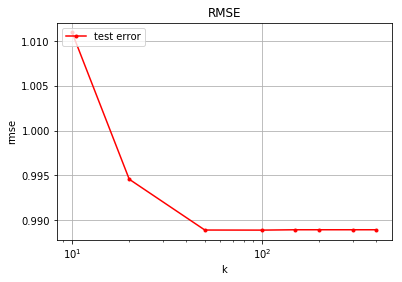

In [91]:
predict_KNNitem_test, rmse = knn_surprise(train,test,None,False, 100)


In [64]:
predict_baseline_test = baseline_surprise(train,test,None)

Estimating biases using als...
number of items: 9990, number of users: 999
1.00127314809


In [78]:
predict_slop_test = slop_surprise(train, test, None)

number of items: 9990, number of users: 999
1.00185650691


In [12]:
%%time
predict_SGD_test = matrix_factorization_SGD(train, test, 0.025, 20, 0.1, 0.016)

learn the matrix factorization using SGD...
iter: 0, RMSE on training set: 1.0072250403037464.
iter: 1, RMSE on training set: 0.9862650810096528.
iter: 2, RMSE on training set: 0.9767306594442242.
iter: 3, RMSE on training set: 0.9672979369494857.
iter: 4, RMSE on training set: 0.9595384374013362.
iter: 5, RMSE on training set: 0.9550054005816746.
iter: 6, RMSE on training set: 0.9491199322348344.
iter: 7, RMSE on training set: 0.9444512792733896.
iter: 8, RMSE on training set: 0.942024289337868.
iter: 9, RMSE on training set: 0.9385325411263757.
iter: 10, RMSE on training set: 0.9357894213885091.
iter: 11, RMSE on training set: 0.9348966510151007.
iter: 12, RMSE on training set: 0.9331614620107427.
iter: 13, RMSE on training set: 0.9322803708923634.
iter: 14, RMSE on training set: 0.9310106123605381.
iter: 15, RMSE on training set: 0.9301341384037939.
iter: 16, RMSE on training set: 0.9294004990629313.
iter: 17, RMSE on training set: 0.9288423160143617.
iter: 18, RMSE on training set:


start the ALS algorithm...
RMSE on training set: 0.9683854696262746.
RMSE on training set: 0.9636641888328061.
RMSE on training set: 0.9622033086723247.
RMSE on training set: 0.9610708830609189.
RMSE on training set: 0.9600981287338146.
RMSE on training set: 0.9593451001369316.
RMSE on training set: 0.9588289719349584.
RMSE on training set: 0.9585034014048226.
RMSE on training set: 0.9583079650772224.
RMSE on training set: 0.958193546877028.
RMSE on training set: 0.9581268728266509.
test RMSE after running ALS: 0.9940086593042198.

start the ALS algorithm...
RMSE on training set: 0.9405068064457816.
RMSE on training set: 0.932032524723315.
RMSE on training set: 0.9294776857135059.
RMSE on training set: 0.9282718400452732.
RMSE on training set: 0.9275919135533452.
RMSE on training set: 0.9271625359773246.
RMSE on training set: 0.9268674126525906.
RMSE on training set: 0.9266502976014707.
RMSE on training set: 0.9264817926749079.
RMSE on training set: 0.9263460915281138.
RMSE on trainin

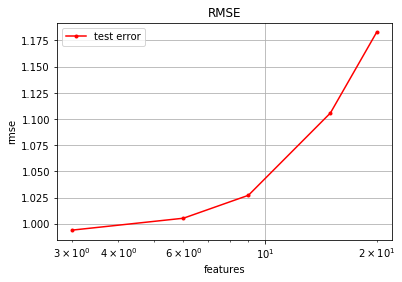

In [103]:
%%time
k = [3,6,9,15,20]
temp = []
for i in k:
    predict_ALS_test, rmse = ALS(train,test,i, 0.2, 0.9)
    temp.append(rmse)
error_visualization(parameter=k,rmse=temp,parameter_name='features')

In [84]:
all_predictions_test = []
all_predictions_test.append(predict_SGD_test)
all_predictions_test.append(predict_ALS_test)
all_predictions_test.append(predict_global_test)
all_predictions_test.append(predict_SVD_test)
all_predictions_test.append(predict_user_test)
all_predictions_test.append(predict_item_test.reshape(9990,1))
#all_predictions_test.append(predict_KNNuser_test)
all_predictions_test.append(predict_KNNitem_test)
all_predictions_test.append(predict_baseline_test)
all_predictions_test.append(predict_slop_test)

In [25]:
def const(x):
    return x.sum() - 1
constraint = {'type':'eq', 'fun': const}

def sum_ratings(weights):
    mix_prediction = 0
    for i, pred in enumerate(all_predictions_test):
        mix_prediction += weights[i] * pred
    return compute_mix_error(test, nz=nnz_test, prediction=mix_prediction)


In [85]:
%%time
x0 = [1/len(all_predictions_test)] * len(all_predictions_test)
result = minimize(fun=sum_ratings, x0=x0)

Wall time: 8min 52s


In [86]:
result

      fun: 0.9783438797774957
 hess_inv: array([[  3.61795446e+01,  -1.22332982e+01,  -7.59384765e+00,
         -4.50707243e+00,   7.08095679e+00,   6.75685887e+00,
         -1.10723045e+01,   4.60003977e-01,  -1.44380023e+01],
       [ -1.22332982e+01,   2.37321970e+01,   2.40183381e+00,
         -4.86570764e+00,  -2.52444956e+00,  -1.81612336e+00,
         -5.53381850e+00,   3.23693668e+00,  -2.62609856e+00],
       [ -7.59384765e+00,   2.40183381e+00,   8.53220321e+01,
          1.84488225e+00,  -8.61062079e+01,  -8.23853539e+01,
          7.44698569e+00,   7.94387734e+01,  -5.13012857e-01],
       [ -4.50707243e+00,  -4.86570764e+00,   1.84488225e+00,
          1.86124642e+01,  -2.95533571e-01,  -2.32854565e+00,
         -2.76289146e+00,  -1.37255060e+01,   8.09006459e+00],
       [  7.08095679e+00,  -2.52444956e+00,  -8.61062079e+01,
         -2.95533571e-01,   1.06644288e+02,   8.58492252e+01,
         -5.05412269e+00,  -1.47234701e+02,   4.19003898e+01],
       [  6.75685887e+00

In [30]:
%%time
predict_global = baseline_global_mean(ratings, None)
predict_user = np.array(baseline_user_mean(ratings, None))
predict_item = np.array(baseline_item_mean(ratings,None)).reshape(10000,1)
predict_SGD = matrix_factorization_SGD(ratings,None, 0.025, 20, 0.1, 0.016)
predict_ALS = ALS(ratings,None, 3, 0.2, 0.9)


learn the matrix factorization using SGD...
iter: 0, RMSE on training set: 1.0077772298209096.
iter: 1, RMSE on training set: 0.9874673516781461.
iter: 2, RMSE on training set: 0.9791561652451246.
iter: 3, RMSE on training set: 0.9664854276673659.
iter: 4, RMSE on training set: 0.9610236928318937.
iter: 5, RMSE on training set: 0.954404504289041.
iter: 6, RMSE on training set: 0.9488151382781861.
iter: 7, RMSE on training set: 0.9452445470249833.
iter: 8, RMSE on training set: 0.943220172534005.
iter: 9, RMSE on training set: 0.9399309085295714.
iter: 10, RMSE on training set: 0.9376427161456169.
iter: 11, RMSE on training set: 0.9354976058218751.
iter: 12, RMSE on training set: 0.9346211851133333.
iter: 13, RMSE on training set: 0.9331561430962585.
iter: 14, RMSE on training set: 0.9324180663798682.
iter: 15, RMSE on training set: 0.9316265109403438.
iter: 16, RMSE on training set: 0.931242025192296.
iter: 17, RMSE on training set: 0.930194470150342.
iter: 18, RMSE on training set: 0.

In [31]:
to_predict = get_to_predict()
predict_SVD = svd_surprise(ratings, None, to_predict )

number of items: 10000, number of users: 1000


In [54]:
predict_KNNitem = knn_surprise(ratings, None, to_predict, False)

Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
train
yes
wtf
number of items: 10000, number of users: 1000


In [68]:
predict_baseline = baseline_surprise(ratings, None, to_predict)

Estimating biases using als...
number of items: 10000, number of users: 1000


In [98]:
predict_slop = slop_surprise(ratings, None, to_predict)

number of items: 10000, number of users: 1000


In [99]:
all_predictions = []
all_predictions.append(predict_SGD)
all_predictions.append(predict_ALS)
all_predictions.append(predict_global)
all_predictions.append(predict_SVD)
all_predictions.append(predict_user)
all_predictions.append(predict_item.reshape(10000,1))
all_predictions.append(predict_KNNitem)
all_predictions.append(predict_baseline)
all_predictions.append(predict_slop)

In [97]:
len(result.x)

9

In [100]:
final_predict = 0
for i, pred in enumerate(all_predictions):
    final_predict += result.x[i] * pred

In [101]:
final_predict[final_predict<1] = 1
final_predict[final_predict>5] = 5

In [102]:
create_csv_submissions(final_predict)

In [73]:
final_predict.shape

(10000, 1000)